IMPORTANDO BIBLIOTECAS

In [70]:
import os, shutil, sys, warnings
import errno
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

PARAMETRIZAÇÃO DA APLICAÇÃO

In [2]:
basedirwin = 'D:\\Git\\IBMEC\\Projeto-DAeA\\Dataset\\CSVS\\'
warnings.simplefilter(action='ignore', category=FutureWarning)

REMOVE CSVs VELHOS E COPIA OS NOVOS

In [123]:
if os.path.exists(basedirwin):
    shutil.rmtree(basedirwin)
else:
    sys.exit("Erro ao apagar o diretório de CSVs antigos. Não encontrado.")

try:
    shutil.copytree('D:\\Git\\IBMEC\\Projeto-DAeA\\CSVS\\', 'D:\\Git\\IBMEC\\Projeto-DAeA\\Dataset\\CSVS\\', dirs_exist_ok=True)
except OSError as err:
    sys.exit("Erro copiando a pasta de CSVs novos: % s" % err)

GERANDO LISTA DE PASTAS

In [124]:
try:
    listadir = os.listdir(basedirwin)
except OSError as err:
    if err.errno == errno.ENOENT:
        sys.exit("Erro listando o diretório de CSVs fonte: % s" % err)

FORMATANDO O ARQUIVO DE VOLUMES

In [125]:
for dir in listadir:
    with open(basedirwin + dir + '\\particoes.csv', 'r+') as file:
        espaco = file.readlines()
        for ln in espaco:
            file.seek(espaco.index(ln))
            dir2 = dir[6:8] + dir[4:6] + dir[0:4]
            ln2 = ln[:-1] + "," + dir2 + "\n"
            with open(basedirwin + dir + '\\particoes2.csv', 'a') as fileNovo:
                fileNovo.write(ln2)
            fileNovo.close()
    file.close()
    os.remove(basedirwin + dir + '\\particoes.csv')
    os.rename(basedirwin + dir + '\\particoes2.csv', basedirwin + dir + '\\particoes.csv')

CARREGANDO OS DADOS DE BACKUP NO DATASET

In [126]:
df_bkp = pd.DataFrame()
for dir in listadir:
    df_bkp = df_bkp.append(pd.read_csv(basedirwin + dir + '\\coletas.csv', header=None))
    # df_bkp = df_bkp.concat(pd.read_csv(basedirwin + dir + '\\coletas.csv'), ignore_index=True)
df_bkp.columns = ['nodename', 'datainicio', 'status', 'result', 'datafim', 'server']

CARREGANDO OS DADOS DE ESPAÇO EM DISCO DAS PARTIÇÕES NO DATASET

In [128]:
df_vol = pd.DataFrame()
for dir in listadir:
    df_vol = df_vol.append(pd.read_csv(basedirwin + dir + '\\particoes.csv', header=None))
df_vol.columns = ['particao', 'total', 'usado', 'livre', 'porcentagem', 'server', 'data']
df_vol['data'] = pd.to_datetime(df_vol['data'], format='%d%m%Y')
df_vol.dtypes

particao               object
total                  object
usado                  object
livre                  object
porcentagem            object
server                 object
data           datetime64[ns]
dtype: object

REMOVENDO SINAIS DOS DADOS (T, G, M, %)

In [129]:
df_vol['total'] = df_vol['total'].str.replace('T|G|M', '')
df_vol['usado'] = df_vol['usado'].str.replace('T|G|M', '')
df_vol['livre'] = df_vol['livre'].str.replace('T|G|M', '')
df_vol['porcentagem'] = df_vol['porcentagem'].str.replace('%', '')

GERANDO DATASETS DE PARTIÇÕES E PORCENTAGEM DE USO POR REGIONAL

In [153]:
# Gerar lista de regionais (list_reg)
list_reg = df_vol['server'].unique()

# Percorrendo list_reg, gerando datasets por regional
for reg in list_reg:
    globals()[f'df_vol_{reg}'] = df_vol[df_vol['server'].str.contains(reg)]

GERANDO GRÁFICOS COM O SEABORN

Text(0.5, 1.0, '/fpool')

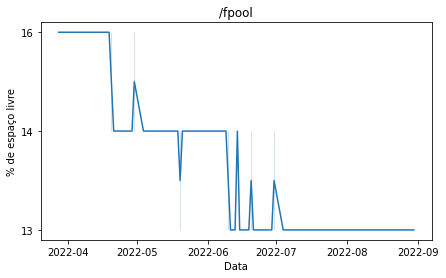

In [158]:
TSM_OPRJO_fpool = df_vol_TSM_OPRJO[df_vol_TSM_OPRJO['particao'] == '/tsm_fpool']
#TSM_OPRJO_fpool = TSM_OPRJO_fpool.drop_duplicates(subset='porcentagem')
TSM_OPRJO_fpool.reset_index(drop=True, inplace=True)
plt.figure(figsize = (7,4))
fpool = sns.lineplot(data = TSM_OPRJO_fpool, x = 'data', y = 'porcentagem')
fpool.set_xlabel('Data', fontsize = 10)
fpool.set_ylabel('% de espaço livre', fontsize = 10)
fpool.set_title('/fpool')